In [1]:
import numpy as np
import copy

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib

import torch
import torch.nn as nn
import torch.nn.functional as F
import dtnnlib as dtnn

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (9, 8)

In [2]:
# device = torch.device("cuda:0")
device = torch.device("cpu")

## On 2D dataset

In [3]:
## Set 1
num_points = 50
X1 = np.linspace(-2.5, 1.5, num_points)
X2 = np.linspace(-2, 4, num_points)
X1, X2 = np.meshgrid(X1, X2)
Y = np.sin(np.sqrt(X1**2 + X2**2))*2-1.

In [4]:
# ## Set 2
# x1min, x1max, nx1 = -5, 6, 75
# x2min, x2max, nx2 = -3, 7, 75
# x1, x2 = np.linspace(x1min, x1max, nx1), np.linspace(x2min, x2max, nx2)
# X1, X2 = np.meshgrid(x1, x2)

# # Our function to fit is going to be a sum of two-dimensional Gaussians
# def gaussian(x1, x2, x10, x20, x1alpha, x2alpha, A):
#     return A * np.exp( -((x1-x10)/x1alpha)**2 -((x2-x20)/x2alpha)**2)

# # A list of the Gaussian parameters: x10, x20, x1alpha, x2alpha, A
# gprms = [(0, 2, 2.5, 5.4, 1.5),
#          (-1, 4, 6, 2.5, 1.8),
#          (-3, -0.5, 1, 2, 4),
#          (3, 0.5, 2, 1, 5)
#         ]

# Y = np.zeros(X1.shape)
# for p in gprms:
#     Y += gaussian(X1, X2, *p)

/home/tsuman/Program_Files/Python/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  # This is added back by InteractiveShellApp.init_path()


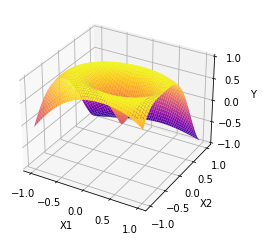

In [5]:
####Scaling the data to range -1,1
X1 = 2*(X1 - X1.min())/(X1.max() - X1.min()) -1
X2 = 2*(X2 - X2.min())/(X2.max() - X2.min()) -1
Y = 2*(Y - Y.min())/(Y.max() - Y.min()) -1

x1 = X1.reshape(-1)
x2 = X2.reshape(-1)

%matplotlib inline
fig = plt.figure()
ax = fig.gca(projection='3d')
# ax.scatter(X1, X2, Y)
ax.plot_surface(X1, X2, Y, cmap='plasma')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
plt.show()

In [6]:
xx = torch.Tensor(np.c_[x1, x2])
yy = torch.Tensor(Y.reshape(-1,1))

## Building 2D model

In [8]:
class LocalMLP(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.new_hidden_dim = 0
        self.output_dim = output_dim
        
#         self.layer0 = dtnn.iStereographicLinearTransform(self.input_dim, self.hidden_dim)
#         self.layer0 = dtnn.DistanceTransform_MinExp(self.input_dim, self.hidden_dim, bias=True)
#         self.layer0 = dtnn.DistanceTransform(self.input_dim, self.hidden_dim, bias=True)
        self.layer0 = dtnn.DistanceTransform_Gaussian(self.input_dim, self.hidden_dim, bias=True)
#         self.layer0 = dtnn.DistanceTransform_Simple(self.input_dim, self.hidden_dim, bias=True)

#         self.activ = dtnn.OneActiv(self.hidden_dim, mode='exp_1.6')
        self.activ = dtnn.OneActiv(self.hidden_dim, mode='relu')
        self.layer1 = nn.Linear(self.hidden_dim, self.output_dim)
        
    def forward(self, x):
        xo = self.layer0(x)
        xo = self.activ(xo)
        xo = self.layer1(xo)
        return xo

In [9]:
model = LocalMLP(2, 4, 1).to(device)

In [10]:
model

LocalMLP(
  (layer0): DistanceTransform_Gaussian()
  (activ): OneActiv()
  (layer1): Linear(in_features=4, out_features=1, bias=True)
)

In [11]:
yout = model.forward(xx)
xx.shape, yout.shape

(torch.Size([2500, 2]), torch.Size([2500, 1]))

In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0031)
criterion = nn.MSELoss()

/home/tsuman/Program_Files/Python/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  This is separate from the ipykernel package so we can avoid doing imports until


0 Error =  0.31066834926605225
200 Error =  0.04468381404876709
400 Error =  0.028667889535427094
600 Error =  0.019515370950102806
800 Error =  0.018521491438150406
1000 Error =  0.018201341852545738
1200 Error =  0.018005015328526497
1400 Error =  0.017854437232017517
1600 Error =  0.01772872917354107
1800 Error =  0.01761685684323311
2000 Error =  0.017512978985905647
2200 Error =  0.017412161454558372
2400 Error =  0.017314787954092026
2600 Error =  0.017200956121087074
2800 Error =  0.017080482095479965
3000 Error =  0.0169630516320467
3200 Error =  0.016870956867933273
3400 Error =  0.016792265698313713
3600 Error =  0.01155870035290718
3800 Error =  0.005646899342536926
4000 Error =  0.004996234085410833
4200 Error =  0.0046421922743320465
4400 Error =  0.004378810990601778
4600 Error =  0.004164734855294228
4800 Error =  0.0039839050732553005


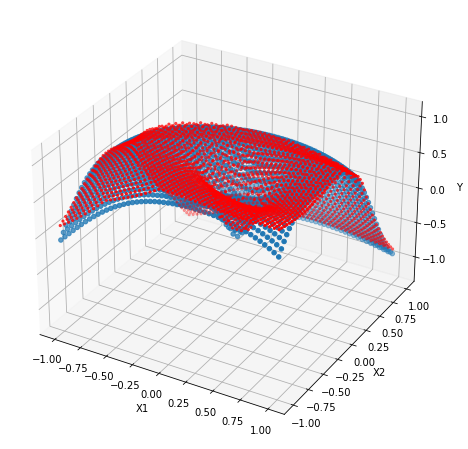

In [13]:
%matplotlib tk
fig = plt.figure(figsize=(9,8))
ax = fig.gca(projection='3d')

for epoch in range(5000):

    yout = model(xx)
    loss = criterion(yout, yy)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch%200 == 0:
        print(epoch, 'Error = ', float(loss))
        ax.clear()
        
        ax.scatter(X1, X2, Y)
        ax.scatter(X1, X2, yout.data.reshape(Y.shape), color='r', marker='.')
        ax.set_xlabel('X1')
        ax.set_ylabel('X2')
        ax.set_zlabel('Y')
        
        fig.canvas.draw()
        plt.pause(0.01)

In [14]:
yout.shape, Y.shape

(torch.Size([2500, 1]), (50, 50))

/home/tsuman/Program_Files/Python/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  This is separate from the ipykernel package so we can avoid doing imports until


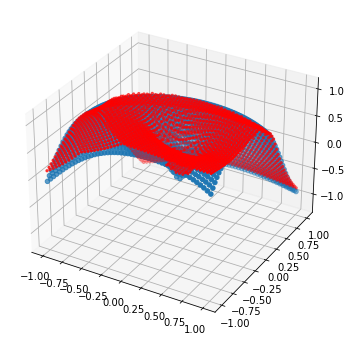

In [15]:
%matplotlib inline
fig = plt.figure(figsize=(8,6))
ax = fig.gca(projection='3d')
ax.scatter(X1, X2, Y)
ax.scatter(X1, X2, yout.data.reshape(-1), color='r', marker='.')
plt.show()

In [16]:
"""
DistanceTransform_MinExp creates sharp change in function (undesirable)
"""

'\nDistanceTransform_MinExp creates sharp change in function (undesirable)\n'

## Softmax based similarity 

In [19]:
class LocalMLPsoftmax(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.new_hidden_dim = 0
        self.output_dim = output_dim
        
#         self.layer0 = dtnn.iStereographicLinearTransform(self.input_dim, self.hidden_dim)
#         self.layer0 = dtnn.DistanceTransform_MinExp(self.input_dim, self.hidden_dim, bias=True)
#         self.layer0 = dtnn.DistanceTransform(self.input_dim, self.hidden_dim, bias=True)
        self.layer0 = dtnn.DistanceTransform_Gaussian(self.input_dim, self.hidden_dim, bias=True)
#         self.layer0 = dtnn.DistanceTransform_Simple(self.input_dim, self.hidden_dim, bias=True)
        self.scale_shift = dtnn.ScaleShift(self.hidden_dim, scaler_init=10, shifter_init=0, scaler_const=True, shifter_const=True)
        self.softmax = nn.Softmax(dim=-1)
#         self.softmax = nn.LogSoftmax(dim=-1)
        self.activ = dtnn.OneActiv(self.hidden_dim, mode='relu')
#         self.activ = dtnn.OneActiv(self.hidden_dim, mode='exp_1.6')
        self.layer1 = nn.Linear(self.hidden_dim, self.output_dim)
        
    def forward(self, x):
        xo = self.layer0(x)
        xo = self.scale_shift(xo)
        xo = self.softmax(xo)
        xo = self.activ(xo)
        xo = self.layer1(xo)
        return xo

In [20]:
model = LocalMLPsoftmax(2, 10, 1)

In [21]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0031)
criterion = nn.MSELoss()

/home/tsuman/Program_Files/Python/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  This is separate from the ipykernel package so we can avoid doing imports until


0 Error =  0.47203129529953003
200 Error =  0.025606466457247734
400 Error =  0.006980817299336195
600 Error =  0.004519528243690729
800 Error =  0.0032625950407236814
1000 Error =  0.002569144358858466
1200 Error =  0.0021785967983305454
1400 Error =  0.0019717509858310223
1600 Error =  0.0018325408454984426
1800 Error =  0.0017324655782431364
2000 Error =  0.001645706593990326
2200 Error =  0.0015776286600157619
2400 Error =  0.0014792013680562377
2600 Error =  0.001408635638654232
2800 Error =  0.001364632393233478
3000 Error =  0.0013153481995686889
3200 Error =  0.0012845946475863457
3400 Error =  0.0012567095691338181
3600 Error =  0.0012333240592852235
3800 Error =  0.0012115857098251581
4000 Error =  0.0011914721690118313
4200 Error =  0.001170976203866303
4400 Error =  0.001086413860321045
4600 Error =  0.000752965803258121
4800 Error =  0.0006939371814951301


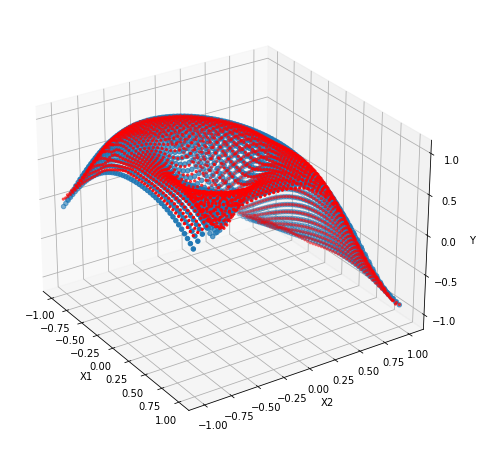

In [22]:
%matplotlib tk
fig = plt.figure(figsize=(9,8))
ax = fig.gca(projection='3d')

for epoch in range(5000):

    yout = model(xx)
    loss = criterion(yout, yy)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch%200 == 0:
        print(epoch, 'Error = ', float(loss))
        ax.clear()
        
        ax.scatter(X1, X2, Y)
        ax.scatter(X1, X2, yout.data.reshape(Y.shape), color='r', marker='.')
        ax.set_xlabel('X1')
        ax.set_ylabel('X2')
        ax.set_zlabel('Y')
        
        fig.canvas.draw()
        plt.pause(0.01)

In [23]:
model.scale_shift.scaler

10

In [24]:
model.scale_shift.shifter

0

In [25]:
def forward_intermediate(self, x):
    xo = self.layer0(x)
    xo = self.scale_shift(xo)
    xo = F.softmax(xo, dim=-1).data
#     xo = F.log_softmax(xo, dim=-1).data
#     xo = self.activ(xo)
#     xo = self.layer1(xo)
#     return xo
    print(xo.shape)
    print(xo.mean(dim=0), "\n ", xo.std(dim=0))
    print(xo.min(dim=0)[0], "\n ", xo.max(dim=0)[0])

In [26]:
forward_intermediate(model, xx)

torch.Size([2500, 10])
tensor([0.0201, 0.0379, 0.0782, 0.2068, 0.0169, 0.2302, 0.0652, 0.1569, 0.1540,
        0.0336]) 
  tensor([0.0743, 0.1147, 0.2060, 0.2005, 0.0963, 0.2348, 0.0781, 0.0884, 0.2293,
        0.1057])
tensor([2.0657e-11, 1.4013e-44, 1.3095e-34, 2.0596e-09, 1.0346e-09, 2.3652e-03,
        1.0842e-04, 6.2516e-06, 3.2789e-17, 8.5294e-37]) 
  tensor([0.6367, 0.8706, 0.9683, 0.7298, 0.9975, 0.7910, 0.2855, 0.3547, 0.7690,
        0.8615])


## Random Initialization with Softmax-10

In [27]:
H = 100
model = LocalMLPsoftmax(2, H, 1)

In [28]:
randidx = torch.randperm(len(xx))[:H]
model.layer0.centers.data = xx[randidx] 
model.layer1.weight.data = yy[randidx].t()

In [29]:
model.layer1.bias.data *= 0.

In [30]:
yout = model(xx)
loss = criterion(yout, yy)
loss

tensor(0.0127, grad_fn=<MseLossBackward>)

/home/tsuman/Program_Files/Python/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  This is separate from the ipykernel package so we can avoid doing imports until


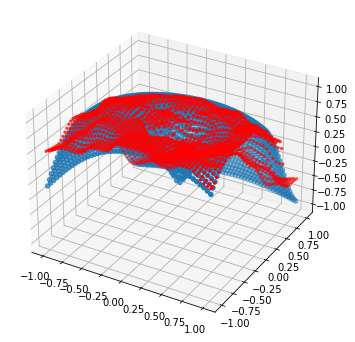

In [31]:
%matplotlib inline
fig = plt.figure(figsize=(8,6))
ax = fig.gca(projection='3d')
ax.scatter(X1, X2, Y)
ax.scatter(X1, X2, yout.data.reshape(-1), color='r', marker='.')
plt.show()

In [32]:
"""
1. Test for 2D classification -> softmax-10 and random init
2. Test e-Softmax (or distance) for activating region of uncertainity (viz decision boundary)
            -> Also try with min-exp
3. Try DT-minExp but with KNN scaled distances (rather than std scaled)
4. Train the function to produce uni-modular activation (using loss function)
5. Train 2D experiments with noisy adding and pruning mechanism (for softmax and updated unimodal neurons) 
"""

'\n1. Test for 2D classification -> softmax-10 and random init\n2. Test e-Softmax (or distance) for activating region of uncertainity (viz decision boundary)\n            -> Also try with min-exp\n3. Try DT-minExp but with KNN scaled distances (rather than std scaled)\n4. Train the function to produce uni-modular activation (using loss function)\n5. Train 2D experiments with noisy adding and pruning mechanism (for softmax and updated unimodal neurons) \n'

## 1. Classification

In [33]:
def twospirals(n_points, noise=.5, angle=784):
    """
     Returns the two spirals dataset.
    """
    n = np.sqrt(np.random.rand(n_points,1)) * angle * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))), 
            np.hstack((np.zeros(n_points),np.ones(n_points))))

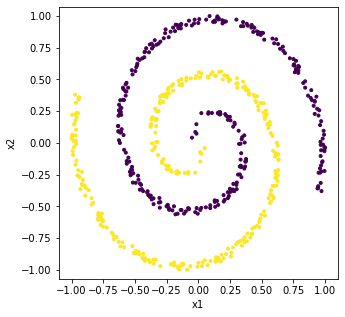

In [34]:
x, y = twospirals(300, angle=560)
x, y = x/x.max(axis=0, keepdims=True), y.reshape(-1)
xx, yy = torch.FloatTensor(x), torch.FloatTensor(y.reshape(-1,1))

x1 = xx[:,0]
x2 = xx[:,1]

%matplotlib inline
plt.figure(figsize=(5,5))
plt.scatter(x1, x2, c=y, marker='.')
# plt.savefig("./clf_toy_data.pdf")
plt.xlabel("x1")
plt.ylabel("x2")
plt.axis("equal")
plt.show()

In [35]:
xx, yy = xx.to(device), yy.to(device)

In [36]:
H = 20
model = LocalMLPsoftmax(2, H, 1)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

Epoch: 99, Acc:0.80, Loss:0.6294576525688171
Epoch: 199, Acc:0.93, Loss:0.5559526681900024
Epoch: 299, Acc:0.97, Loss:0.4952525198459625
Epoch: 399, Acc:1.00, Loss:0.4495545029640198
Epoch: 499, Acc:1.00, Loss:0.40508005023002625
Epoch: 599, Acc:1.00, Loss:0.37112361192703247
Epoch: 699, Acc:1.00, Loss:0.3420681059360504
Epoch: 799, Acc:1.00, Loss:0.31590235233306885
Epoch: 899, Acc:1.00, Loss:0.2903917133808136
Epoch: 999, Acc:1.00, Loss:0.26751476526260376


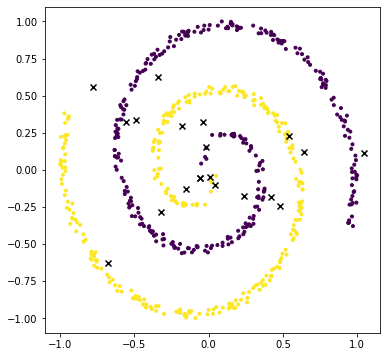

Epoch: 1099, Acc:1.00, Loss:0.24528539180755615
Epoch: 1199, Acc:1.00, Loss:0.2235899567604065
Epoch: 1299, Acc:1.00, Loss:0.20510414242744446
Epoch: 1399, Acc:1.00, Loss:0.18931740522384644
Epoch: 1499, Acc:1.00, Loss:0.17437143623828888
Epoch: 1599, Acc:1.00, Loss:0.16073152422904968
Epoch: 1699, Acc:1.00, Loss:0.14959564805030823
Epoch: 1799, Acc:1.00, Loss:0.1385529339313507
Epoch: 1899, Acc:1.00, Loss:0.12842957675457
Epoch: 1999, Acc:1.00, Loss:0.1199611946940422


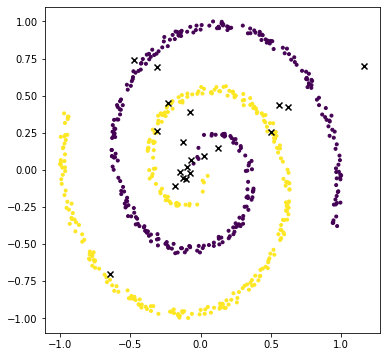

Epoch: 2099, Acc:1.00, Loss:0.11237304657697678
Epoch: 2199, Acc:1.00, Loss:0.1054999902844429
Epoch: 2299, Acc:1.00, Loss:0.09924135357141495
Epoch: 2399, Acc:1.00, Loss:0.09350341558456421
Epoch: 2499, Acc:1.00, Loss:0.08820033073425293
Epoch: 2599, Acc:1.00, Loss:0.08313635736703873
Epoch: 2699, Acc:1.00, Loss:0.07793865352869034
Epoch: 2799, Acc:1.00, Loss:0.07332999259233475
Epoch: 2899, Acc:1.00, Loss:0.06897424906492233
Epoch: 2999, Acc:1.00, Loss:0.06462307274341583


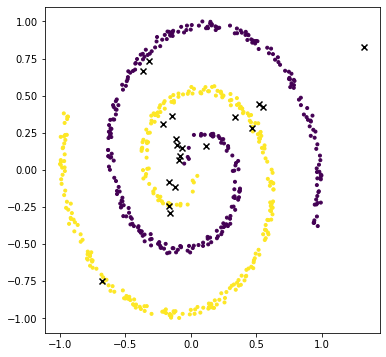

Epoch: 3099, Acc:1.00, Loss:0.06096695736050606
Epoch: 3199, Acc:1.00, Loss:0.05771706998348236
Epoch: 3299, Acc:1.00, Loss:0.05435260757803917
Epoch: 3399, Acc:1.00, Loss:0.05058148875832558
Epoch: 3499, Acc:1.00, Loss:0.0478411540389061
Epoch: 3599, Acc:1.00, Loss:0.04537510499358177
Epoch: 3699, Acc:1.00, Loss:0.04308667406439781
Epoch: 3799, Acc:1.00, Loss:0.04095034301280975
Epoch: 3899, Acc:1.00, Loss:0.03894883394241333
Epoch: 3999, Acc:1.00, Loss:0.03706922009587288


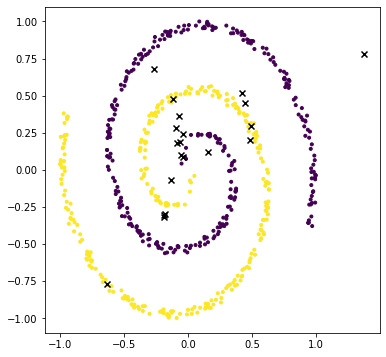

Epoch: 4099, Acc:1.00, Loss:0.03530145063996315
Epoch: 4199, Acc:1.00, Loss:0.03363381698727608
Epoch: 4299, Acc:1.00, Loss:0.03206031769514084
Epoch: 4399, Acc:1.00, Loss:0.030573535710573196
Epoch: 4499, Acc:1.00, Loss:0.029167000204324722
Epoch: 4599, Acc:1.00, Loss:0.02783515304327011
Epoch: 4699, Acc:1.00, Loss:0.0265725739300251
Epoch: 4799, Acc:1.00, Loss:0.02537522278726101
Epoch: 4899, Acc:1.00, Loss:0.02423829585313797
Epoch: 4999, Acc:1.00, Loss:0.023158308118581772


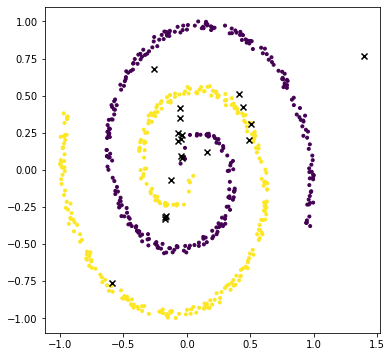

In [37]:
for epoch in range(5000):
    yout = torch.sigmoid(model(xx))
    loss = criterion(yout, yy)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1)%100 == 0:
        accuracy = ((yout>0.5).type(torch.float32) == yy).type(torch.float).mean()                
        print(f'Epoch: {epoch}, Acc:{float(accuracy):.2f}, Loss:{float(loss)}')

    if (epoch+1)%1000 == 0:
        ax = plt.figure(figsize=(6,6)).add_subplot()
        out = (yout.data.cpu().numpy()>0.5).astype(int)
        ax.scatter(x1, x2, c=out, marker= '.')
        ## plot centroids
        c = model.layer0.centers.data.cpu()
        ax.scatter(c[:,0], c[:,1], color='k', marker= 'x')
        plt.show()

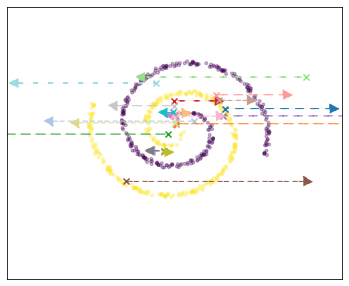

In [38]:
yout = torch.sigmoid(model(xx))
ax = plt.figure(figsize=(6,5)).add_subplot()
out = (yout.data.cpu().numpy()>0.5).astype(int)
ax.scatter(x1, x2, c=out, marker= '.', alpha=0.3)
## plot centroids
c = model.layer0.centers.data.cpu()
# ax.scatter(c[:,0], c[:,1], color='g', marker= 'x')
d = model.layer1.weight.data.cpu().t()*0.5 #+ net.net[-1].bias.data.cpu()
# print(d.shape)

for i in range(c.shape[0]):
    color = matplotlib.cm.tab20(i)
#     ax.arrow(c[i,0], c[i,1], d[i,0], d[i,1], head_width=0.05, head_length=0.1, fc='k', ec='k')
#     ax.arrow(c[i,0], c[i,1], d[i,0], d[i,1], head_width=0.15, head_length=0.1, fc=color, ec=color, linestyle=(0, (5, 10)))
    ax.arrow(c[i,0], c[i,1], d[i,0], 0, head_width=0.15, head_length=0.1, fc=color, ec=color, linestyle=(0, (5, 10)))
    ax.scatter(c[i,0], c[i,1], color=color, marker= 'x')
    
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.xlim(-1.9, 1.8)
plt.ylim(-2.2, 1.8)

# plt.savefig("./outputs/", bbox_inches='tight')
plt.show()

#### Random Init

In [46]:
H = 10
model = LocalMLPsoftmax(2, H, 1)
model

LocalMLPsoftmax(
  (layer0): DistanceTransform_Gaussian()
  (scale_shift): ScaleShift()
  (softmax): Softmax(dim=-1)
  (activ): OneActiv()
  (layer1): Linear(in_features=10, out_features=1, bias=True)
)

In [47]:
randidx = torch.randperm(len(xx))[:H]

In [48]:
model.layer0.centers.data = xx[randidx] 

## Mapping like MLP
model.layer1.weight.data = (yy[randidx].t()*2-1)*1.0
# print(model.layer1.weight.data.shape, yy[randidx].t().shape)

## Residual like difference
# sign = yy[randidx].t()*2-1
# xval = xx[randidx, 0]
# diff = sign-xval
# model.layer1.weight.data = diff


model.layer1.bias.data *= 0.
yout = torch.sigmoid(model(xx))
loss = criterion(yout, yy)
accuracy = ((yout>0.5).type(torch.float32) == yy).type(torch.float).mean()
loss.item(), accuracy.item()

(0.6952509880065918, 0.6100000143051147)

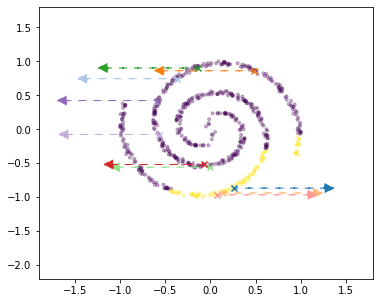

In [49]:
yout = torch.sigmoid(model(xx))
ax = plt.figure(figsize=(6,5)).add_subplot()
out = (yout.data.cpu().numpy()>0.5).astype(int)
ax.scatter(x1, x2, c=out, marker= '.', alpha=0.3)
## plot centroids
c = model.layer0.centers.data.cpu()
# ax.scatter(c[:,0], c[:,1], color='g', marker= 'x')
d = model.layer1.weight.data.cpu().t() #+ net.net[-1].bias.data.cpu()
# print(d.shape)

for i in range(c.shape[0]):
    color = matplotlib.cm.tab20(i%20)
#     ax.arrow(c[i,0], c[i,1], d[i,0], d[i,1], head_width=0.05, head_length=0.1, fc='k', ec='k')
#     ax.arrow(c[i,0], c[i,1], d[i,0], d[i,1], head_width=0.15, head_length=0.1, fc=color, ec=color, linestyle=(0, (5, 10)))
    ax.arrow(c[i,0], c[i,1], d[i,0], 0, head_width=0.15, head_length=0.1, fc=color, ec=color, linestyle=(0, (5, 10)))
    ax.scatter(c[i,0], c[i,1], color=color, marker= 'x')
    
# plt.tick_params(left = False, right = False , labelleft = False ,
#                 labelbottom = False, bottom = False)
plt.xlim(-1.9, 1.8)
plt.ylim(-2.2, 1.8)

# plt.savefig("./outputs/", bbox_inches='tight')
plt.show()

In [50]:
yout.shape, out.shape

(torch.Size([600, 1]), (600, 1))

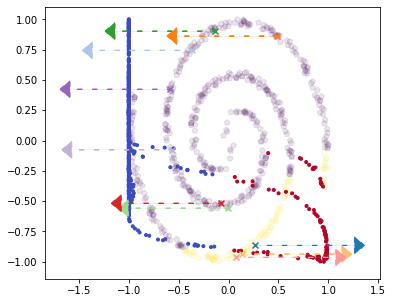

In [51]:
# yout = torch.sigmoid(model(xx))
yout = model(xx)
ax = plt.figure(figsize=(6,5)).add_subplot()
out = (yout.data.cpu().numpy()>0.0).astype(int)

ax.scatter(x1, x2, c=out, marker= 'p', alpha=0.1)

# ax.scatter(yout[:,0].data.numpy(), [0]*len(yout), c=out, marker= '.', alpha=0.3)
ax.scatter(yout[:,0].data.numpy(), x2, c=out, marker= '.', alpha=1.0, cmap="coolwarm")
## plot centroids
c = model.layer0.centers.data.cpu()
d = model.layer1.weight.data.cpu().t() #+ net.net[-1].bias.data.cpu()

for i in range(c.shape[0]):
    color = matplotlib.cm.tab20(i%20)
    ax.arrow(c[i,0], c[i,1], d[i,0], 0, head_width=0.15, head_length=0.1, fc=color, ec=color, linestyle=(0, (5, 10)))
    ax.scatter(c[i,0], c[i,1], color=color, marker= 'x')

# plt.xlim(-1.9, 1.8)
# plt.ylim(-2.2, 1.8)
plt.show()

## epsilon-Softmax neuron

In [173]:
class EpsilonSoftmax(nn.Module):
    '''
    Assuming the minimum distance is below epsilon.
    '''
    def __init__(self, dim=-1, epsilon:float=0.1, maxima_above_epsilon:bool=True):
        super().__init__()
        self.dim= dim
        self.epsilon = epsilon
        self.sign = 1
        if not maxima_above_epsilon:
            self.sign = -1
            
    def forward(self, x):
        ## x shape=[batch_size, dimensions]
        bs, _ = x.shape
#         return torch.log_softmax(
        return torch.softmax(
            torch.cat([self.sign*x, torch.ones(bs, 1, device=x.device)*self.epsilon], dim=self.dim), 
            dim=self.dim)#[:, :-1]

In [204]:
class LocalMLP_epsilonsoftmax(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, epsilon=0.1):
        super().__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.new_hidden_dim = 0
        self.output_dim = output_dim
        
#         self.layer0 = dtnn.iStereographicLinearTransform(self.input_dim, self.hidden_dim)
#         self.layer0 = dtnn.DistanceTransform_MinExp(self.input_dim, self.hidden_dim, bias=True)
#         self.layer0 = dtnn.DistanceTransform(self.input_dim, self.hidden_dim, bias=True)
#         self.layer0 = dtnn.DistanceTransform_Gaussian(self.input_dim, self.hidden_dim, bias=True)
        self.layer0 = dtnn.DistanceTransform_Simple(self.input_dim, self.hidden_dim, bias=True)
    
        self.scale_shift = dtnn.ScaleShift(self.hidden_dim, scaler_init=10, shifter_init=0, scaler_const=True, shifter_const=True)
        self.softmax = EpsilonSoftmax(dim=-1, epsilon=epsilon)
        self.activ = dtnn.OneActiv(self.hidden_dim+1, mode='relu')
#         self.activ = dtnn.OneActiv(self.hidden_dim+1, mode='exp_1.6')
        self.layer1 = nn.Linear(self.hidden_dim+1, self.output_dim)
        
    def forward(self, x):
        xo = self.layer0(x)
        xo = self.scale_shift(xo)
        xo = self.softmax(xo)
        xo = self.activ(xo)
        xo = self.layer1(xo)
        return xo

In [205]:
H = 10
model = LocalMLP_epsilonsoftmax(2, H, 1, epsilon=0.3)
model(xx).shape

torch.Size([600, 1])

In [206]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

Epoch: 99, Acc:0.76, Loss:0.6481207609176636
Epoch: 199, Acc:0.89, Loss:0.5917463898658752
Epoch: 299, Acc:0.94, Loss:0.5340264439582825
Epoch: 399, Acc:0.95, Loss:0.4864324927330017
Epoch: 499, Acc:0.95, Loss:0.44689446687698364
Epoch: 599, Acc:0.95, Loss:0.41634079813957214
Epoch: 699, Acc:0.95, Loss:0.39069637656211853
Epoch: 799, Acc:0.95, Loss:0.3683948814868927
Epoch: 899, Acc:0.95, Loss:0.34705066680908203
Epoch: 999, Acc:0.96, Loss:0.32252028584480286


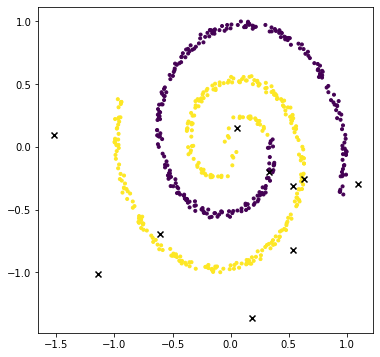

Epoch: 1099, Acc:0.96, Loss:0.3023563027381897
Epoch: 1199, Acc:0.97, Loss:0.2818763256072998
Epoch: 1299, Acc:0.99, Loss:0.24855387210845947
Epoch: 1399, Acc:0.99, Loss:0.22648023068904877
Epoch: 1499, Acc:0.99, Loss:0.2092343419790268
Epoch: 1599, Acc:0.99, Loss:0.19364222884178162
Epoch: 1699, Acc:0.99, Loss:0.18046985566616058
Epoch: 1799, Acc:0.99, Loss:0.16900913417339325
Epoch: 1899, Acc:0.99, Loss:0.1587550938129425
Epoch: 1999, Acc:0.99, Loss:0.1494590938091278


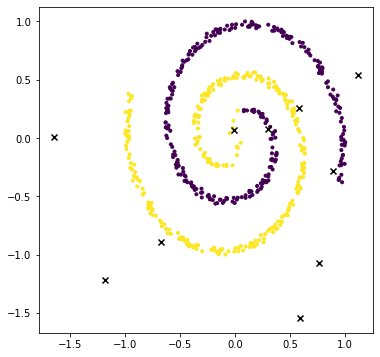

Epoch: 2099, Acc:0.99, Loss:0.1410209834575653
Epoch: 2199, Acc:0.99, Loss:0.13327965140342712
Epoch: 2299, Acc:0.99, Loss:0.12626497447490692
Epoch: 2399, Acc:0.99, Loss:0.11985870450735092
Epoch: 2499, Acc:0.99, Loss:0.11390554904937744
Epoch: 2599, Acc:0.99, Loss:0.10847876220941544
Epoch: 2699, Acc:0.99, Loss:0.10347595065832138
Epoch: 2799, Acc:0.99, Loss:0.09886307269334793
Epoch: 2899, Acc:0.99, Loss:0.09459582716226578
Epoch: 2999, Acc:0.99, Loss:0.09064208716154099


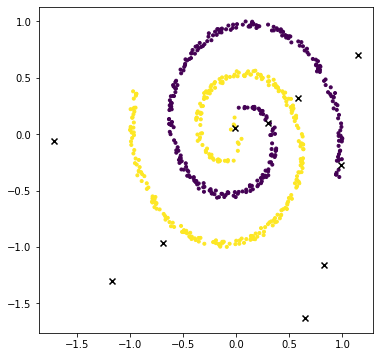

Epoch: 3099, Acc:0.99, Loss:0.08697453886270523
Epoch: 3199, Acc:0.99, Loss:0.0835452750325203
Epoch: 3299, Acc:0.99, Loss:0.08030212670564651
Epoch: 3399, Acc:1.00, Loss:0.06798122078180313
Epoch: 3499, Acc:1.00, Loss:0.06303720921278
Epoch: 3599, Acc:1.00, Loss:0.0589786022901535
Epoch: 3699, Acc:1.00, Loss:0.055443909019231796
Epoch: 3799, Acc:1.00, Loss:0.052255794405937195
Epoch: 3899, Acc:1.00, Loss:0.04932554066181183
Epoch: 3999, Acc:1.00, Loss:0.04660004377365112


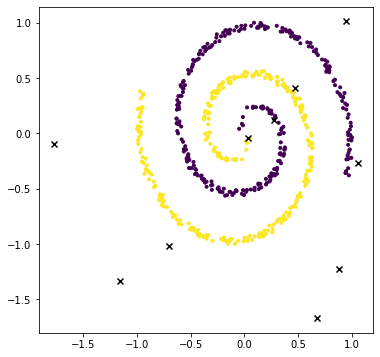

Epoch: 4099, Acc:1.00, Loss:0.044101420789957047
Epoch: 4199, Acc:1.00, Loss:0.04178681969642639
Epoch: 4299, Acc:1.00, Loss:0.039636511355638504
Epoch: 4399, Acc:1.00, Loss:0.037618279457092285
Epoch: 4499, Acc:1.00, Loss:0.03571633994579315
Epoch: 4599, Acc:1.00, Loss:0.03393714874982834
Epoch: 4699, Acc:1.00, Loss:0.03226734325289726
Epoch: 4799, Acc:1.00, Loss:0.03069993108510971
Epoch: 4899, Acc:1.00, Loss:0.02922082506120205
Epoch: 4999, Acc:1.00, Loss:0.027819471433758736


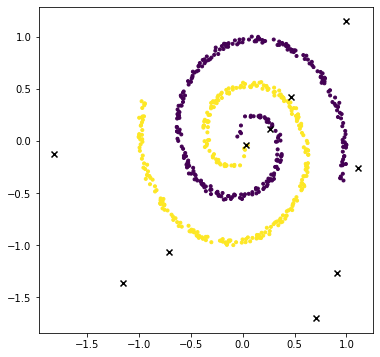

In [207]:
for epoch in range(5000):
    yout = torch.sigmoid(model(xx))
    loss = criterion(yout, yy)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1)%100 == 0:
        accuracy = ((yout>0.5).type(torch.float32) == yy).type(torch.float).mean()                
        print(f'Epoch: {epoch}, Acc:{float(accuracy):.2f}, Loss:{float(loss)}')

    if (epoch+1)%1000 == 0:
        ax = plt.figure(figsize=(6,6)).add_subplot()
        out = (yout.data.cpu().numpy()>0.5).astype(int)
        ax.scatter(x1, x2, c=out, marker= '.')
        ## plot centroids
        c = model.layer0.centers.data.cpu()
        ax.scatter(c[:,0], c[:,1], color='k', marker= 'x')
        plt.show()

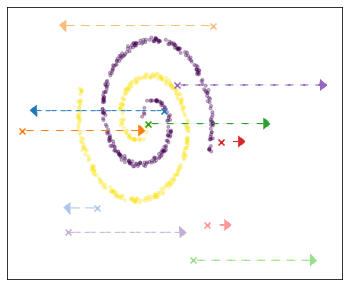

In [208]:
yout = torch.sigmoid(model(xx))
ax = plt.figure(figsize=(6,5)).add_subplot()
out = (yout.data.cpu().numpy()>0.5).astype(int)
ax.scatter(x1, x2, c=out, marker= '.', alpha=0.3)
## plot centroids
c = model.layer0.centers.data.cpu()
# ax.scatter(c[:,0], c[:,1], color='g', marker= 'x')
d = model.layer1.weight.data.cpu().t()*0.5 #+ net.net[-1].bias.data.cpu()
# print(d.shape)

for i in range(c.shape[0]):
    color = matplotlib.cm.tab20(i)
#     ax.arrow(c[i,0], c[i,1], d[i,0], d[i,1], head_width=0.05, head_length=0.1, fc='k', ec='k')
#     ax.arrow(c[i,0], c[i,1], d[i,0], d[i,1], head_width=0.15, head_length=0.1, fc=color, ec=color, linestyle=(0, (5, 10)))
    ax.arrow(c[i,0], c[i,1], d[i,0], 0, head_width=0.15, head_length=0.1, fc=color, ec=color, linestyle=(0, (5, 10)))
    ax.scatter(c[i,0], c[i,1], color=color, marker= 'x')
    
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
# plt.xlim(-1.9, 1.8)
# plt.ylim(-2.2, 1.8)

# plt.savefig("./outputs/", bbox_inches='tight')
plt.show()

#### Random Init

In [209]:
H = 10
# model = LocalMLP_epsilonsoftmax(2, H, 1, epsilon=0.1)
model = LocalMLP_epsilon(2, H, 1, epsilon=0.1)
model

LocalMLP_epsilonsoftmax(
  (layer0): DistanceTransform_Simple()
  (scale_shift): ScaleShift()
  (softmax): EpsilonSoftmax()
  (activ): OneActiv()
  (layer1): Linear(in_features=11, out_features=1, bias=True)
)

In [210]:
randidx = torch.randperm(len(xx))[:H]

In [211]:
model.layer0.centers.data = xx[randidx] 

## Mapping like MLP
out = (yy[randidx].t()*2-1)*1.0
out = torch.cat([out, torch.ones(1, 1)*0.], dim=1)
model.layer1.weight.data = out
# print(model.layer1.weight.data.shape, yy[randidx].t().shape)

## Residual like difference
# sign = yy[randidx].t()*2-1
# xval = xx[randidx, 0]
# diff = sign-xval
# model.layer1.weight.data = diff


model.layer1.bias.data *= 0.
yout = torch.sigmoid(model(xx))
loss = criterion(yout, yy)
accuracy = ((yout>0.5).type(torch.float32) == yy).type(torch.float).mean()
loss.item(), accuracy.item()

(0.6596336364746094, 0.6100000143051147)

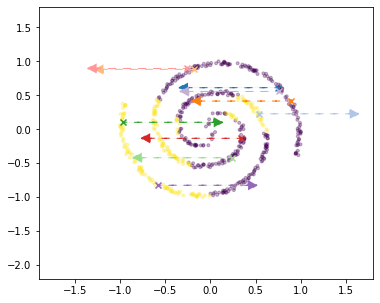

In [212]:
yout = torch.sigmoid(model(xx))
ax = plt.figure(figsize=(6,5)).add_subplot()
out = (yout.data.cpu().numpy()>0.5).astype(int)
ax.scatter(x1, x2, c=out, marker= '.', alpha=0.3)
## plot centroids
c = model.layer0.centers.data.cpu()
# ax.scatter(c[:,0], c[:,1], color='g', marker= 'x')
d = model.layer1.weight.data.cpu().t() #+ net.net[-1].bias.data.cpu()
# print(d.shape)

for i in range(c.shape[0]):
    color = matplotlib.cm.tab20(i%20)
#     ax.arrow(c[i,0], c[i,1], d[i,0], d[i,1], head_width=0.05, head_length=0.1, fc='k', ec='k')
#     ax.arrow(c[i,0], c[i,1], d[i,0], d[i,1], head_width=0.15, head_length=0.1, fc=color, ec=color, linestyle=(0, (5, 10)))
    ax.arrow(c[i,0], c[i,1], d[i,0], 0, head_width=0.15, head_length=0.1, fc=color, ec=color, linestyle=(0, (5, 10)))
    ax.scatter(c[i,0], c[i,1], color=color, marker= 'x')
    
# plt.tick_params(left = False, right = False , labelleft = False ,
#                 labelbottom = False, bottom = False)
plt.xlim(-1.9, 1.8)
plt.ylim(-2.2, 1.8)

# plt.savefig("./outputs/", bbox_inches='tight')
plt.show()

In [213]:
yout.shape, out.shape

(torch.Size([600, 1]), (600, 1))

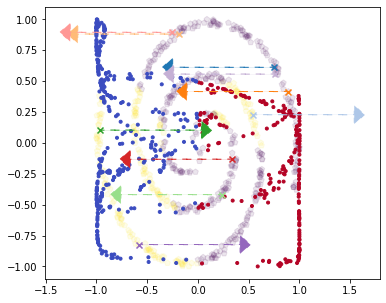

In [214]:
# yout = torch.sigmoid(model(xx))
yout = model(xx)
ax = plt.figure(figsize=(6,5)).add_subplot()
# out = (yout.data.cpu().numpy()>0.5).astype(int)
out = (yout.data.cpu().numpy()>0.0).astype(int)

ax.scatter(x1, x2, c=out, marker= 'p', alpha=0.1)

# ax.scatter(yout[:,0].data.numpy(), [0]*len(yout), c=out, marker= '.', alpha=0.3)
ax.scatter(yout[:,0].data.numpy(), x2, c=out, marker= '.', alpha=1.0, cmap="coolwarm")
## plot centroids
c = model.layer0.centers.data.cpu()
d = model.layer1.weight.data.cpu().t() #+ net.net[-1].bias.data.cpu()

for i in range(c.shape[0]):
    color = matplotlib.cm.tab20(i%20)
    ax.arrow(c[i,0], c[i,1], d[i,0], 0, head_width=0.15, head_length=0.1, fc=color, ec=color, linestyle=(0, (5, 10)))
    ax.scatter(c[i,0], c[i,1], color=color, marker= 'x')

# plt.xlim(-1.9, 1.8)
# plt.ylim(-2.2, 1.8)
plt.show()

#### Visualize the confidence per neuron in a grid

In [215]:
def forward_intermediate(self, x):
    xo = self.layer0(x)
    xo = self.scale_shift(xo)
    xo = self.softmax(xo).data
    return xo

In [216]:
xo = forward_intermediate(model, xx)

print(xo.shape)
print(xo.mean(dim=0), "\n ", xo.std(dim=0))
print(xo.min(dim=0)[0], "\n ", xo.max(dim=0)[0])

torch.Size([600, 11])
tensor([0.0469, 0.1020, 0.0431, 0.0959, 0.1435, 0.1798, 0.1191, 0.0794, 0.1477,
        0.0403, 0.0022]) 
  tensor([0.1282, 0.2103, 0.1386, 0.1918, 0.3113, 0.3048, 0.2065, 0.1628, 0.3120,
        0.0948, 0.0029])
tensor([3.0702e-09, 2.0759e-07, 4.3162e-09, 2.5024e-08, 5.3807e-09, 5.3588e-07,
        1.8665e-06, 2.5468e-08, 1.7864e-09, 4.2699e-09, 2.8926e-05]) 
  tensor([0.5972, 0.9373, 0.7962, 0.6808, 0.9999, 0.9522, 0.9382, 0.6808, 0.9998,
        0.5745, 0.0179])


In [217]:
num_points = 1000
X1 = np.linspace(-1.5, 1.5, num_points)*2
X2 = np.linspace(-1.5, 1.5, num_points)*2
X1, X2 = np.meshgrid(X1, X2)

XX = torch.Tensor(np.c_[X1.reshape(-1), X2.reshape(-1)]).to(device)

In [218]:
YY = forward_intermediate(model, XX)
YY = YY.reshape(num_points, num_points, H+1)
YY.shape

torch.Size([1000, 1000, 11])

In [219]:
max_actv = forward_intermediate(model, model.layer0.centers.data.cpu())
# plt.imshow(max_actv)
max_actv = max_actv.diag().numpy()

(1000, 1000)
center: 0.5972044 max_grid: 0.59671915 True


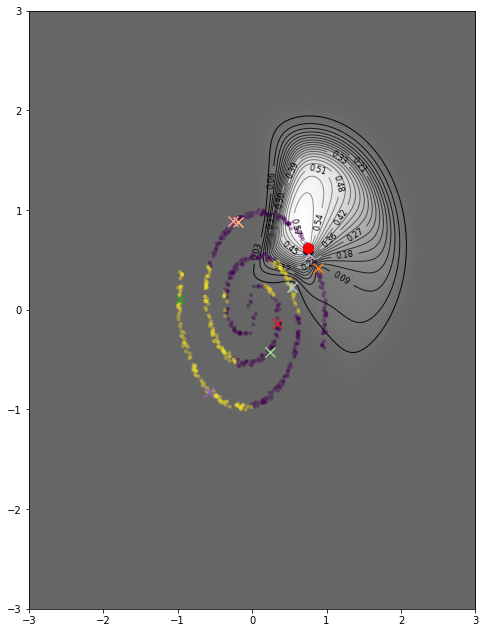

(1000, 1000)
center: 0.93733907 max_grid: 0.9361879 True


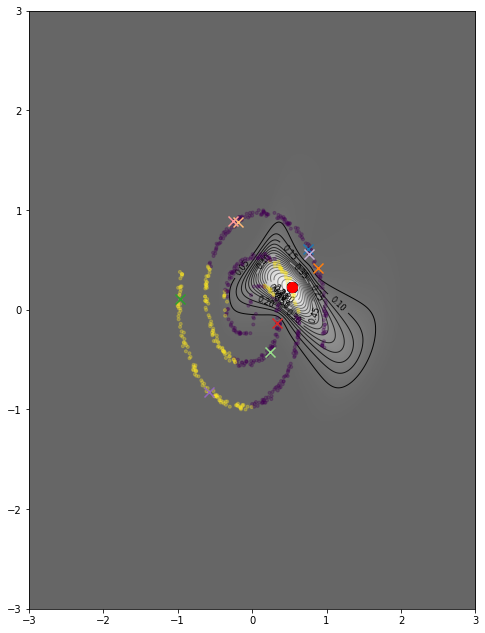

(1000, 1000)
center: 0.79619455 max_grid: 0.79499507 True


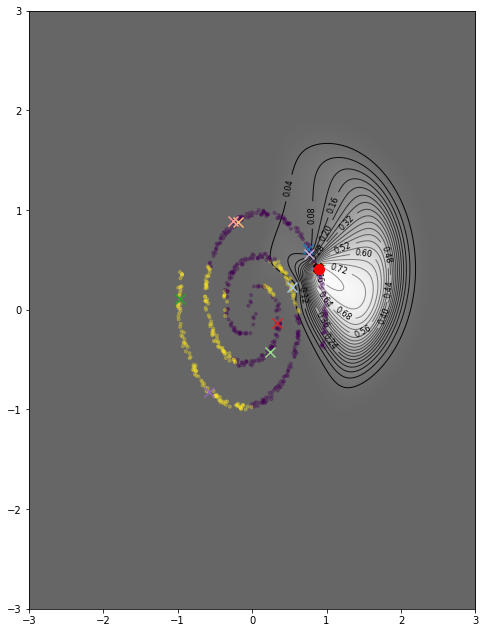

(1000, 1000)
center: 0.68076545 max_grid: 0.6807456 True


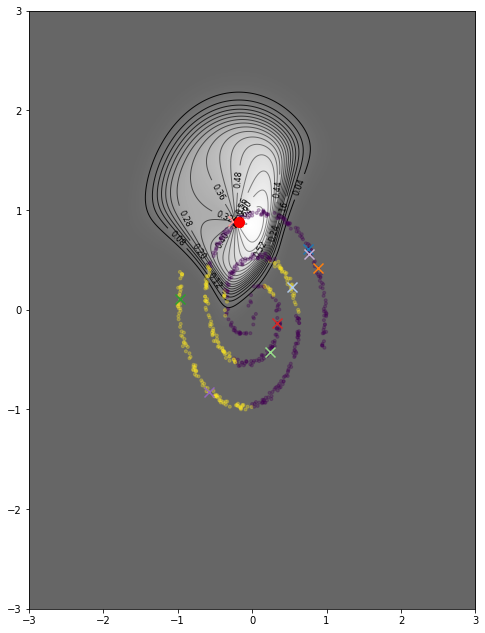

(1000, 1000)
center: 0.9998597 max_grid: 0.99985754 True


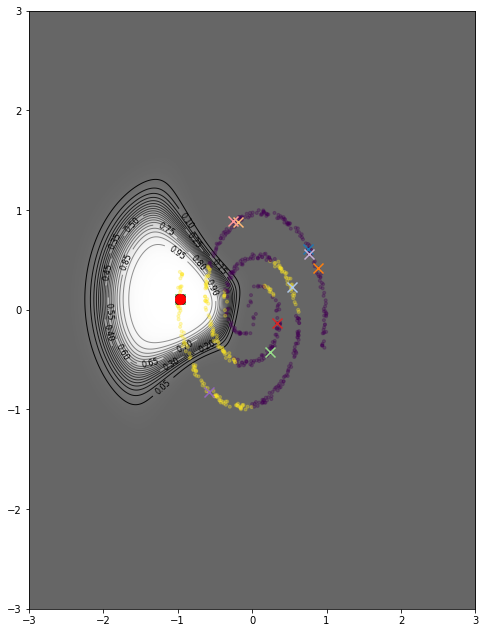

(1000, 1000)
center: 0.9522333 max_grid: 0.9522065 True


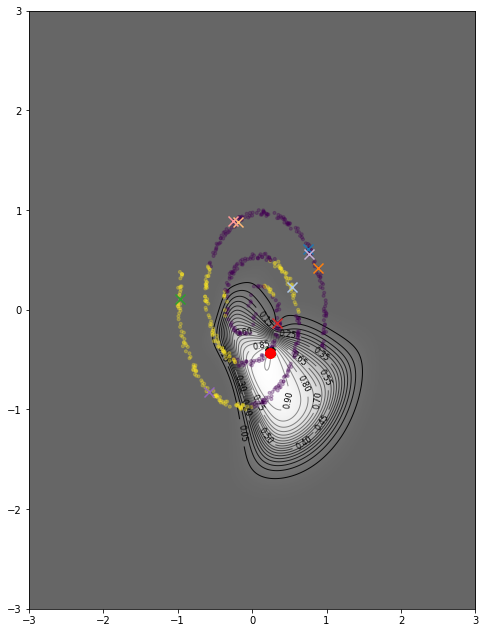

(1000, 1000)
center: 0.93816996 max_grid: 0.9373178 True


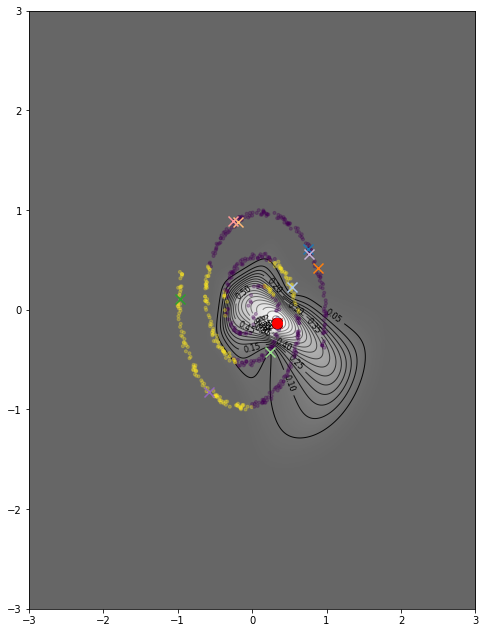

(1000, 1000)
center: 0.6808047 max_grid: 0.68079585 True


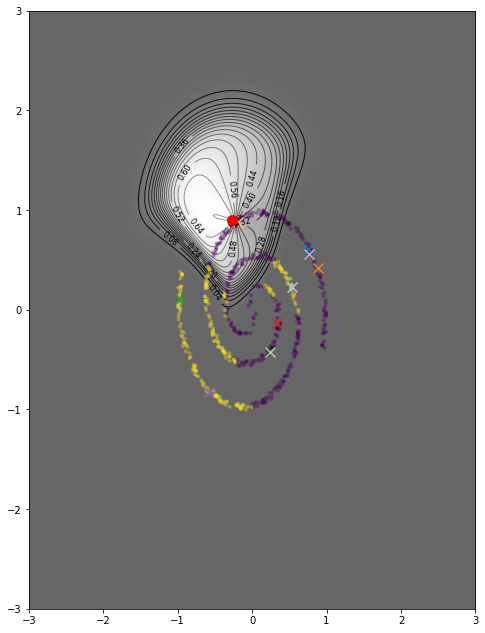

(1000, 1000)
center: 0.9997929 max_grid: 0.99979025 True


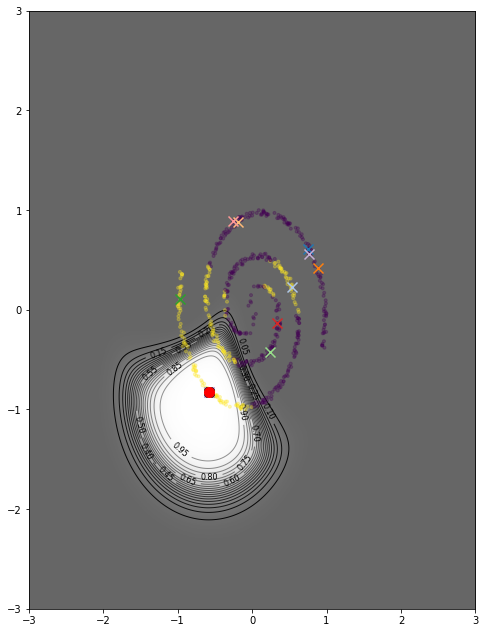

(1000, 1000)
center: 0.57535756 max_grid: 0.57284176 True


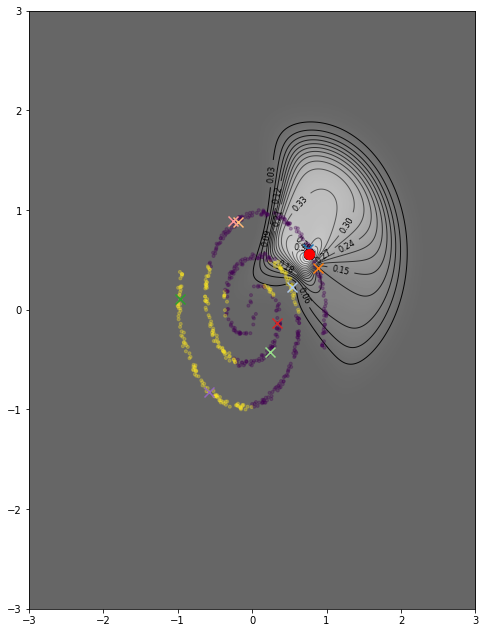

(1000, 1000)


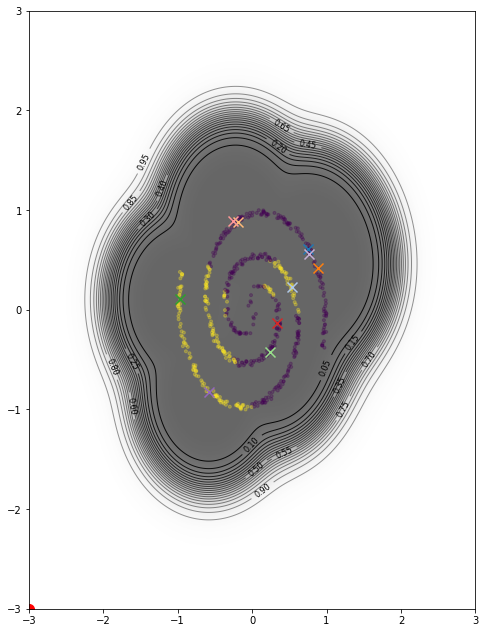

In [220]:
for idx in range(xo.shape[1]):
    conf = YY[:,:,idx]
    conf = conf.data.cpu().numpy().reshape(X1.shape)
    print(conf.shape)
    
    ax = plt.figure(figsize=(8,11)).add_subplot()

    ax.scatter(x1, x2, c=out, marker= '.', alpha=0.3)

    ## plot centroids
    c = model.layer0.centers.data.cpu()
#     d = model.layer1.weight.data.cpu().t() #+ net.net[-1].bias.data.cpu()
    for i in range(c.shape[0]):
        color = matplotlib.cm.tab20(i%20)
#         ax.arrow(c[i,0], c[i,1], d[i,0], 0, head_width=0.15, head_length=0.1, fc=color, ec=color, linestyle=(0, (5, 10)))
        ax.scatter(c[i,0], c[i,1], color=color, marker= 'x', s=100)
    
    try:
        ax.scatter(c[idx,0], c[idx,1], color="k", marker= 'X', s=100)
        ## to check difference between DT_gaussian vs DT_simple
        print(f"center:",max_actv[idx],"max_grid:",conf.max(), max_actv[idx] >= conf.max())
    except:
        pass
    
#     maxpt = np.unravel_index(conf.argmax(), conf.shape)
    maxpt = XX[conf.argmax()]
    ax.scatter(maxpt[0], maxpt[1], color="r", marker= 'o', s=100)
#     print(maxpt)
    
    plt.imshow(conf, interpolation='nearest',
           extent=(X1.min(), X1.max(), X2.min(), X2.max()),
           alpha=0.6, cmap='gray',
           aspect='auto', origin='lower')
    
    LVLs = 20
#     ax.contourf(X1, X2, conf, levels=LVLs)
    cs = ax.contour(X1, X2, conf, levels=LVLs, linestyles="None", colors="k", linewidths=1, zorder=-2)
    ax.clabel(cs, cs.levels, inline=True, fontsize=8, fmt="%1.2f")
    
    # plt.xlim(-1.9, 1.8)
    # plt.ylim(-2.2, 1.8)
    plt.show()
#     break

In [103]:
# model.layer0.

In [104]:
# maxpt = np.unravel_index(conf.argmax(), conf.shape)
# maxpt

In [61]:
# XX[conf.argmax()]

In [62]:
model

LocalMLP_epsilonsoftmax(
  (layer0): DistanceTransform_Gaussian()
  (scale_shift): ScaleShift()
  (softmax): EpsilonSoftmax()
  (activ): OneActiv()
  (layer1): Linear(in_features=11, out_features=1, bias=True)
)

In [63]:
"""
(All with softmax)
- Distance transform without normalization gives local region of confidence
        - The maximum does not lie at the center
        - Not scaling the distance (gaussian) or scaling-monotonic helps keep the center at maxima
        - epsilon does not lie in between centers (or at the decision boundary) for simple neg-distance
- Distance transform with Normalization gives angular confidence
        - The epsilon also lie around the decision boundary of centers
- Distance transform w/o Norm and d-d_min produces global region..
        - Epsilon lie around db, and are sharp for dtmin
        - for (d-dmin), the maxima and center are same, but extends beyond other centers radially.
        - The maxima still lie at center (but are more like angular confidence) 
        - May use combined with dt-w/o-nrom -> min(d1, d2) to be absolutely sure of decision...
        
- Extend this to iStereoGraphicTransform -> to make it scale well to high dimensions
"""
print()

In [64]:
"""
for:
dists = torch.exp(-(dists.abs())+self.scaler)
- works well with sqrt scaling or without
- the scaling (/std) keeps desired center minima, and local activation
- the min shift to 0, makes the confidence radial

dists = (1-dists)*torch.exp(self.scaler)
- works similar to exp, but the contours are more tightly packed..

[can combine normalized dist and unnormalized dist to make confidence prediction-> min(C(d_norm), C(d))]
[may take halfway to nearest center as confidence threshold at first]


BIG Question: how to scale to high dim, where the activation is high 
    (eg: most poins lie at dist of 20 in fMNIST)
    1 - dividing by std helps
    2 - cenering to mean hampers the epsilon, works differently
    
    
Try to scale by sigma (to topK value range)    
Try to not use softmax (use dists = cat([epsilon, dists] and use dist-min(dist) to calculate closest ones) 
    - using this with sigma, allows one to predict using max-actv = 1, but sum-actv > 1 for prediction.

"""

'\nfor:\ndists = torch.exp(-(dists.abs())+self.scaler)\n- works well with sqrt scaling or withour\n- the scaling (/std) keeps desired center minima, and local activation\n- the min shift to 0, makes the confidence radial\n\ndists = (1-dists)*torch.exp(self.scaler)\n- works similar to exp, but the contours are more tightly packed..\n\n[can combine normalized dist and unnormalized dist to make confidence prediction-> min(C(d_norm), C(d))]\n[may take halfway to nearest center as confidence threshold at first]\n\n\nBIG Question: how to scale to high dim, where the activation is high \n    (eg: most poins lie at dist of 20 in fMNIST)\n    1 - normalization helps\n    2 - \n\n'

In [65]:
asdasd

NameError: name 'asdasd' is not defined

In [ ]:
## Best option is to use simple distance transform with softmax-temp

In [ ]:
### Experimentals/NN_Func_Approx/Invertible_Flow_NN/multi_invex_func/03.3_Multi_Invex_MSE_classifier_2D_Iterative_v0(NqW).ipynb

# class LeakySignum(nn.Module):
#     def forward(self, x):
#         o1x = 0.1*x
#         return torch.minimum(torch.maximum(x, o1x), o1x+0.9)
    
# class DistanceMulticlassClassifier(nn.Module):
    
#     def __init__(self,input_dim, num_sets, output_dim, inv_temp=1):
#         super().__init__()
#         self.input_dim = input_dim
#         self.output_dim = output_dim
#         self.num_sets = num_sets
        
#         self.centers = nn.Parameter(torch.rand(num_sets, input_dim)*2-1)
#         self.bias = nn.Parameter(torch.ones(1, num_sets)*-1)
#         self.inv_temp = nn.Parameter(torch.ones(1, num_sets)*inv_temp)
        
# #         init_val = torch.ones(num_sets, output_dim)/output_dim
#         init_val = torch.randn(num_sets, output_dim)*0.1
#         for ns in range(num_sets):
#             init_val[ns, ns%output_dim] = 1.
#         self.cls_weight = nn.Parameter(init_val.abs())

#         self.cls_confidence = None
#         self.dist_loss = 0
        
# #         self.actf = nn.Sigmoid()
#         self.actf = LeakySignum()
# #         self.actf = LeakyRectFilter()
        
#     def forward(self, x, hard=False):
# #         self.cls_weight.data.abs_()
# #         self.cls_weight.data = self.cls_weight.data/self.cls_weight.data.sum(dim=1, keepdim=True)
        
#         x = x[:, :self.input_dim]
#         dists = torch.cdist(x, self.centers)
#         dists = dists/np.sqrt(self.input_dim) ### correction to make diagonal of unit square 1 in nD space
# #         dists = dists*self.inv_temp + self.bias
#         dists = dists + self.bias

# #         if hard:
#         dists = self.actf(-dists)
#         indices = torch.argmax(dists, dim=1)
#         c = torch.softmax(self.cls_weight, dim=1)

#         probs = c[indices]
#         scaler = dists[torch.arange(len(indices), dtype=torch.long), indices]
# #         print(scaler)
# #         print(probs)

#         x = torch.softmax(dists, dim=1)
#         y = probs*scaler.reshape(-1, 1)
    
#         self.cls_confidence = scaler.data
# #         self.dist_loss = -torch.cdist(x, self.centers).mean()
# #         return x@c
#         return y

In [ ]:
# H = 20
# model = DistanceMulticlassClassifier(2, H, 2)

# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# criterion = nn.BCELoss()

In [ ]:
# for epoch in range(5000):
#     yout = model(xx)[:, :1]
#     loss = criterion(yout, yy)

#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()

#     if (epoch+1)%l == 0:
#         accuracy = ((yout>0.5).type(torch.float32) == yy).type(torch.float).mean()                
#         print(f'Epoch: {epoch}, Acc:{float(accuracy):.2f}, Loss:{float(loss)}')

#     if (epoch+1)%1000 == 0:
#         ax = plt.figure(figsize=(6,6)).add_subplot()
#         out = (yout.data.cpu().numpy()>0.5).astype(int)
#         ax.scatter(x1, x2, c=out, marker= '.')
#         ## plot centroids
#         c = model.centers.data.cpu()
#         ax.scatter(c[:,0], c[:,1], color='k', marker= 'x')
#         plt.show()

In [77]:
import inspect

In [80]:
print(inspect.getsource(dtnn.DistanceTransform_Simple))

class DistanceTransform_Gaussian(DistanceTransformBase):
    
    def __init__(self, input_dim, num_centers, p=2, bias=False, eps=1e-5):
        super().__init__(input_dim, num_centers, p=2)
        
        self.scaler = nn.Parameter(torch.log(torch.ones(1, num_centers)*3/3))
#         self.bias = nn.Parameter(torch.ones(1, num_centers)*-0.1) if bias else None
        self.bias = nn.Parameter(torch.ones(1, num_centers)*0) if bias else None
        self.eps = eps
        
    def forward(self, x):
        dists = super().forward(x)
        
        ### normalize similar to UMAP

#         dists = dists-dists.min(dim=1, keepdim=True)[0]
#         dists = dists-dists.mean(dim=1, keepdim=True)
        dists = dists/torch.sqrt(dists.var(dim=1, keepdim=True)+self.eps)

#         a = ((-dists-2)*self.scaler).data.cpu().numpy()
#         print(a.mean(), a.std(), a.min(), a.max())

#         dists = torch.exp(-dists**2+self.scaler) ## the gaussian
    
#         dists = torch.exp(-(dists.abs()